## 🏠 House Prices - Random Forest 

### Destaques do Random Forest  

* **Pré-processamento inicial:** leitura dos dados e remoção de colunas com mais de 10% de valores ausentes, garantindo um conjunto de treino consistente e sem variáveis excessivamente incompletas.

* **Transformação das variáveis:** aplicação de imputação por mediana e padronização nas variáveis numéricas, enquanto as categóricas são convertidas via One-Hot Encoding. Todo o fluxo é integrado em um único ColumnTransformer para assegurar coerência durante treino e inferência.

* **Treinamento do modelo:** construção de um pipeline com o RandomForest,sem ajustes hiperparâmetros e com ajuste. O modelo é treinado utilizando a variável alvo em escala logarítmica para maior estabilidade e desempenho preditivo.



## 1. Bibliotecas

In [1]:
# =====================================================
# 🏠 House Prices - Random Forest 
# =====================================================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, 
                       message='Found unknown categories in columns')
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Scikit-learn - Model selection e avaliação
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV

# Scikit-learn - Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Scikit-learn - Ensemble methods
from sklearn.ensemble import RandomForestRegressor

# Scikit-learn - Métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from joblib import dump,load

In [2]:
## 2. Dataload & preprocessamento

In [3]:
# =====================================================
# 📁 1. Leitura dos dados
# =====================================================
dfo = pd.read_csv("/home/akel/PycharmProjects/Kaggle/HousePrices/data/train.csv")
df_train=dfo.copy()
# =====================================================
# ⚙️ 2. carregamento dos preprocessador 
# =====================================================
preprocessador0 = load("preprocessador_v0.joblib")

# =====================================================
# 🧹 3. Pré-processamento inicial
# =====================================================
# remoção de colunas com muitos nulos (> 10%)
colnull_train=df_train.columns[(df_train.isnull().sum()/df_train.shape[0]>0.1)] # 
df_train=df_train.drop(columns=colnull_train,axis=1)
id_train=df_train['Id']

# =====================================================
#  🤖 4.Modelos
# =====================================================
model_rf0 = RandomForestRegressor(random_state=42)
RF0       = pipe_models(model_rf0, preprocessador0)


model_rf1 = RandomForestRegressor(bootstrap=True, max_depth=25, max_features=0.3,
                      min_samples_split=2,  min_samples_leaf= 1,n_estimators=100, n_jobs=-1,
                      random_state=42)
RF1       = pipe_models(model_rf1, preprocessador0)

## 2.Treinamento

In [4]:
X=df_train.drop(['Id', 'SalePrice'], axis=1)
y_log=np.log1p(df_train['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)
RF0.fit(X_train, y_train)
y_pred = RF0.predict(X_test)

res0=metricas_model(y_test, y_pred, 'RF-0')
r20=valida(X,y_log,model=RF0,N=7)

🤖 RF-0
MAE:   0.0934
RMSE: 0.1384
R²:   0.8871
validação cruzada (K-Fold Cross Validation)
Fold 1: R² = 0.8789
Fold 2: R² = 0.9049
Fold 3: R² = 0.8818
Fold 4: R² = 0.7527
Fold 5: R² = 0.8739
Fold 6: R² = 0.8812
Fold 7: R² = 0.8891

📊 R² médio: 0.8661 ± 0.0472


In [5]:
RF1.fit(X_train, y_train)
y_pred = RF1.predict(X_test)

res1=metricas_model(y_test, y_pred, 'RF-1')
r21=valida(X,y_log,model=RF1,N=7)

🤖 RF-1
MAE:   0.0905
RMSE: 0.1375
R²:   0.8886
validação cruzada (K-Fold Cross Validation)
Fold 1: R² = 0.8800
Fold 2: R² = 0.9081
Fold 3: R² = 0.8857
Fold 4: R² = 0.7927
Fold 5: R² = 0.8814
Fold 6: R² = 0.8888
Fold 7: R² = 0.8943

📊 R² médio: 0.8758 ± 0.0351


,Modelo,MAE,RMSE,R²
0,RF-0,0.0934,0.1384,0.8871
1,RF-1,0.0905,0.1375,0.8886


,Modelo,R2_Médio,R2_Std
0,RF0,0.866057,0.047203
1,RF1,0.875838,0.035063


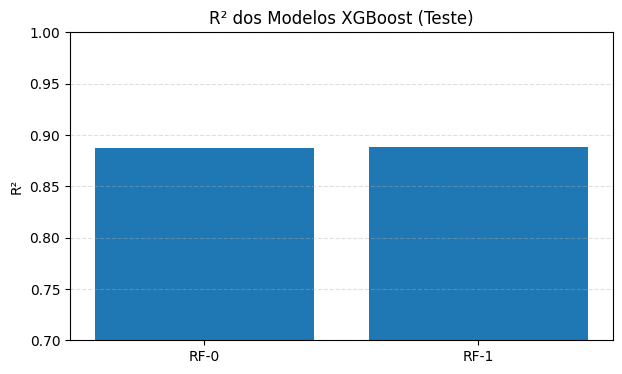

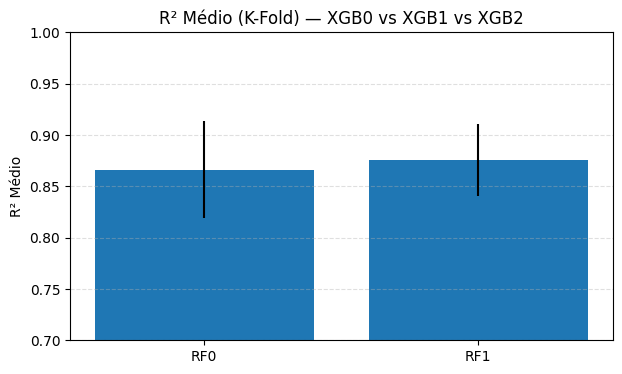

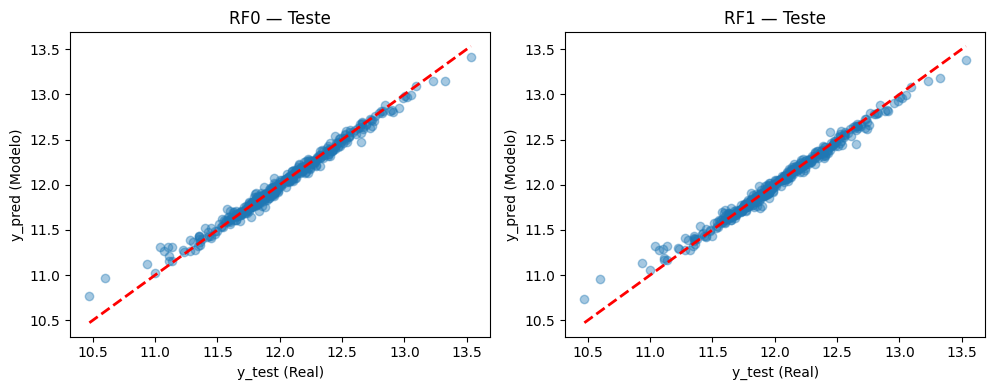

In [7]:
import matplotlib.pyplot as plt

# =====================================================
# 1. Organizar resultados em DataFrame
# =====================================================

resultados_teste = pd.DataFrame([
    res0, res1])

resultados_cv = pd.DataFrame({
    "Modelo": ["RF0", "RF1"],
    "R2_Médio": [np.mean(r20), np.mean(r21),],
    "R2_Std":   [np.std(r20),  np.std(r21)]
})

display(resultados_teste)
display(resultados_cv)

# =====================================================
# 2. Gráfico — R² no conjunto de teste
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_teste['Modelo'], resultados_teste['R²'])
plt.title("R² dos Modelos XGBoost (Teste)")
plt.ylabel("R²")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 3. Gráfico — R² médio da validação cruzada
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_cv['Modelo'], resultados_cv['R2_Médio'], yerr=resultados_cv['R2_Std'])
plt.title("R² Médio (K-Fold) — XGB0 vs XGB1 vs XGB2")
plt.ylabel("R² Médio")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 4. Gráfico de Dispersão — y_test vs y_pred para cada modelo
# =====================================================

predicoes = {
    "RF0": RF0.predict(X_test),
    "RF1": RF1.predict(X_test)

}

plt.figure(figsize=(15,4))

for i, (nome, y_p) in enumerate(predicoes.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_p, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.title(f"{nome} — Teste")
    plt.xlabel("y_test (Real)")
    plt.ylabel("y_pred (Modelo)")

plt.tight_layout()
plt.show()